In [1]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import cv2
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import time
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from numba import jit
from pathlib import Path
from scipy.spatial import KDTree
import networkx as nx
from tqdm import tqdm
import matplotlib.patches as mpatches
#import tables

In [2]:
#x = utils.get_data(directory= r'D:\runs\Run_33_66_72_1_2021-06-24')
x = utils.get_data(directory= r'D:\runs\Run_21_18_56_1_2021-07-12')
#x = utils.get_data(test=True)

# Assign mother cells

In [3]:
df = x.positions
#x.get_colony_areas()

In [4]:

def plot_colony(obj,ts,colors=None,colony=None,ax=None,by=None,dims=x.metadata['Dimensions']):
    if not hasattr(obj,'colonies'):
        obj.get_mothers()
    df = obj.colonies
    ax = ax or plt.gca()
    timepoint = ts
  

    img_size = 2000
    bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)
    if by == 'Species' or by == 'species' or by == 'type':
        colors = {1 : (26,150,65) ,2 : (230,97,1)}
        tp = df[df.Timestep == timepoint]
        circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                    round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                    color = (int(colors[type_][0]),int(colors[type_][1]),int(colors[type_][2])),thickness = -1) for x,y, radius,type_ in zip(tp.x,tp.y,tp.radius,tp.type)]
    elif colony == None and by == None:
        tp = df[df.Timestep == timepoint]
        circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                    round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                    color = (int(colors[cell][0]),int(colors[cell][1]),int(colors[cell][2])),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]
    else:
        color = colors
        tp = df[(df.Timestep == timepoint) & (df.mother_cell==colony)]
        circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                    round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                    color = (int(color[0]),int(color[1]),int(color[2])),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]

    ax.imshow(bk)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

Assigning ancestry: 100%|██████████| 350/350 [00:24<00:00, 14.46it/s]


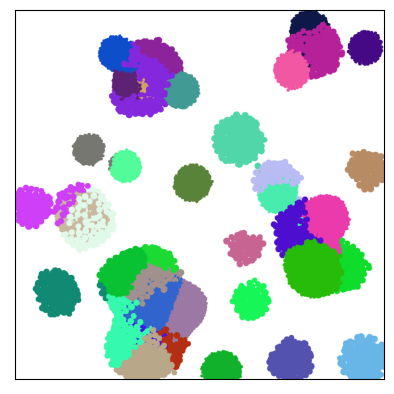

In [5]:
#IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
#colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}
f,ax = plt.subplots()
plot.colony(x,35000,ax=ax)
plt.show()
f.tight_layout()
#f.savefig('testcolony.png')

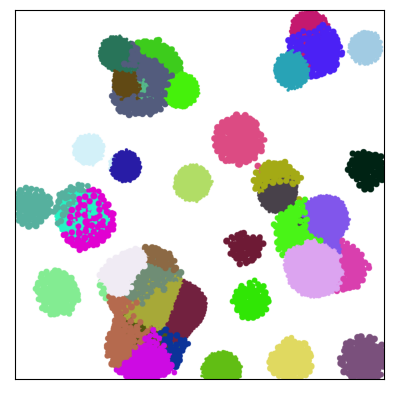

In [6]:
f,ax = plt.subplots()
plot.colony(x,35000,ax=ax)
plt.show()

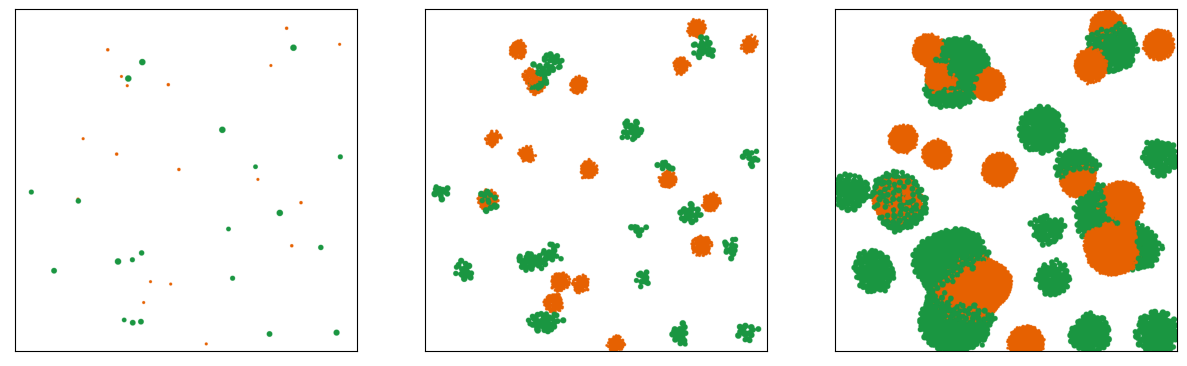

In [7]:
IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}
f, axes = plt.subplots(ncols=3,figsize=(15,5))

for ax, time in zip(axes,[100,20000,35000]):
    plot.colony(x,time,by='Species',ax=ax)
plt.show()
f.tight_layout()
f.savefig('Colonies over time.png')

In [8]:
IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}
#imgs= [plot_colony(df,time,colors) for time in tqdm(df.Timestep.unique())]

In [9]:
df

,Timestep,ID,type,radius,x,y,z,biomass,time,mother_cell
0,0,39,2,4.670000e-07,0.000033,0.000022,0.000002,100.681866,0.000000,39
1,0,7,1,9.350000e-07,0.000037,0.000016,0.000005,1266.849913,0.000000,7
2,0,23,2,5.000000e-07,0.000045,0.000022,0.000006,123.569311,0.000000,23
3,0,26,2,5.100000e-07,0.000027,0.000012,0.000006,131.132741,0.000000,26
4,0,11,1,9.300000e-07,0.000033,0.000020,0.000008,1246.634607,0.000000,11
...,...,...,...,...,...,...,...,...,...,...
1386542,35000,9094,2,4.677101e-07,0.000055,0.000099,0.000010,101.141830,97.222222,25
1386543,35000,12701,2,4.870045e-07,0.000057,0.000099,0.000010,114.182517,97.222222,25
1386544,35000,17474,2,4.239991e-07,0.000058,0.000099,0.000010,75.352136,97.222222,25
1386545,35000,6977,2,4.672515e-07,0.000054,0.000100,0.000010,100.844612,97.222222,25


In [10]:
from joblib import Parallel, delayed
#imgs = Parallel(n_jobs=6)(delayed(plot_colony)(df,time,colors) for time in tqdm(df.Timestep.unique()))
#result = np.stack(imgs)
#im = delayed(np.stack)(imgs)

In [11]:
IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}

In [12]:
df['Colony Area'] = 0
def count_colony_area(df,timestep,dims=x.metadata['Dimensions']):

    tp = df[df.Timestep == timestep]
    colonies = sorted(tp[tp.mother_cell != -1].mother_cell.unique())
    colors = {x :[x]*3 for x in colonies}
    img_size = 2000
    bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)
    circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                color = (cell,0,0),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]
    cols, counts = np.unique(bk[:,:,0],return_counts=1)
    for colony,area in zip(cols[:-1],counts[:-1]):
        idx = df[(df.mother_cell==int(colony)) & (df.Timestep==timestep)].index
        df.loc[idx,'Colony Area'] = area

    

    return df




In [13]:
df2 = count_colony_area(df,35000)
df2

,Timestep,ID,type,radius,x,y,z,biomass,time,mother_cell,Colony Area
0,0,39,2,4.670000e-07,0.000033,0.000022,0.000002,100.681866,0.000000,39,0
1,0,7,1,9.350000e-07,0.000037,0.000016,0.000005,1266.849913,0.000000,7,0
2,0,23,2,5.000000e-07,0.000045,0.000022,0.000006,123.569311,0.000000,23,0
3,0,26,2,5.100000e-07,0.000027,0.000012,0.000006,131.132741,0.000000,26,0
4,0,11,1,9.300000e-07,0.000033,0.000020,0.000008,1246.634607,0.000000,11,0
...,...,...,...,...,...,...,...,...,...,...,...
1386542,35000,9094,2,4.677101e-07,0.000055,0.000099,0.000010,101.141830,97.222222,25,28829
1386543,35000,12701,2,4.870045e-07,0.000057,0.000099,0.000010,114.182517,97.222222,25,28829
1386544,35000,17474,2,4.239991e-07,0.000058,0.000099,0.000010,75.352136,97.222222,25,28829
1386545,35000,6977,2,4.672515e-07,0.000054,0.000100,0.000010,100.844612,97.222222,25,28829


In [14]:
df

,Timestep,ID,type,radius,x,y,z,biomass,time,mother_cell,Colony Area
0,0,39,2,4.670000e-07,0.000033,0.000022,0.000002,100.681866,0.000000,39,0
1,0,7,1,9.350000e-07,0.000037,0.000016,0.000005,1266.849913,0.000000,7,0
2,0,23,2,5.000000e-07,0.000045,0.000022,0.000006,123.569311,0.000000,23,0
3,0,26,2,5.100000e-07,0.000027,0.000012,0.000006,131.132741,0.000000,26,0
4,0,11,1,9.300000e-07,0.000033,0.000020,0.000008,1246.634607,0.000000,11,0
...,...,...,...,...,...,...,...,...,...,...,...
1386542,35000,9094,2,4.677101e-07,0.000055,0.000099,0.000010,101.141830,97.222222,25,28829
1386543,35000,12701,2,4.870045e-07,0.000057,0.000099,0.000010,114.182517,97.222222,25,28829
1386544,35000,17474,2,4.239991e-07,0.000058,0.000099,0.000010,75.352136,97.222222,25,28829
1386545,35000,6977,2,4.672515e-07,0.000054,0.000100,0.000010,100.844612,97.222222,25,28829


In [15]:
areas = count_colony_area(df,35000)

In [16]:
winners =df2[df2.Timestep==df2.Timestep.max()].sort_values(by='Colony Area',ascending=False)[['mother_cell','type','Colony Area']].drop_duplicates().reset_index(drop=True)
winners.mother_cell.unique()

array([22, 11, 17, 18,  8,  5,  3,  1, 33, 12, 20, 14, 15, 29,  2, 24, 13,
       19, 28, 10, 27, 21,  4,  9, 25, 36, 23, 26, 32,  7, 31, 35, 37, 34,
       38, 16,  6, 30, 39], dtype=int64)

In [17]:
winners

,mother_cell,type,Colony Area
0,22,2,80099
1,11,1,68211
2,17,1,65598
3,18,1,58081
4,8,1,57375
5,5,1,55826
6,3,1,55641
7,1,1,55309
8,33,2,52092
9,12,1,52015


In [18]:
winners[winners.type==2].tail()

,mother_cell,type,Colony Area
32,37,2,20006
33,34,2,18784
34,38,2,18217
37,30,2,2802
38,39,2,2536


In [19]:

x.single_cell_growth()


AttributeError: 'get_data' object has no attribute 'h5'

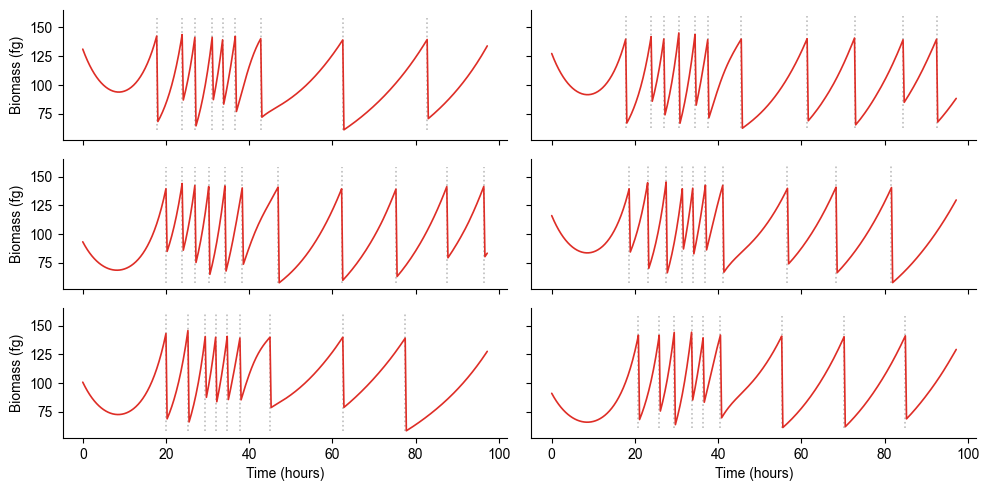

In [20]:
n = 3
f, axes = plt.subplots(nrows=n,ncols=2,figsize=(10,5),sharex=True,sharey=True)
sns.set_context('paper')
sns.set_style('white')
#plot.biomass_time(x.single_cell_biomass,id=11,ax=axes[0,0])
for i,cell in enumerate(winners[winners.type==2].tail(n).mother_cell):
    plot.biomass_time(x.positions,id=cell,ax=axes[i,0])
for i,cell in enumerate(winners[winners.type==2].head(n).mother_cell):
    plot.biomass_time(x.positions,id=cell,ax=axes[i,1])

for ax in axes[:,1].ravel():
    ax.set_ylabel('')
for ax in axes[:2,:].ravel():
    ax.set_xlabel('')
f.tight_layout()
plt.show()

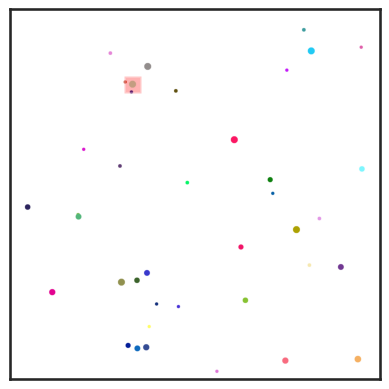

In [ ]:

f, ax = plt.subplots()
plot.colony(x,0,ax=ax)
temp = df[(df.ID==11) & (df.Timestep==0)]
img_size=2000
scale = 5
radius = temp.radius.values
w= scale*radius/x.metadata['Dimensions'][0]*2000
h=scale*radius/x.metadata['Dimensions'][0]*2000

xx = (temp.x/x.metadata['Dimensions'][0]*img_size)-w/2
yy = (temp.y/x.metadata['Dimensions'][1]*img_size)-h/2
rect=mpatches.Rectangle((xx,yy),w,h, 
                        fill = True,
                        facecolor = "red",alpha=0.3,
                        linewidth = 2)
plt.gca().add_patch(rect)
plt.show()

In [ ]:
def colony(obj,time,colors=None,colony=None,ax=None,by=None,img=np.array([]),overlay=False,**kwargs):
    """
    Plot bacterial colonies at a specific timepoint

    Args:
        obj (nufeb_tools.utils.get_data): 
            Object containing cell locations
        time (int): 
            Simulation timestep to plot
        colors (dict, optional): 
            Dictionary of colors to plot each colony. Defaults to None.
        colony (int, optional): 
            Plot a specific colony. Defaults to None.
        ax (matplotlib.pyplot.axes, optional): 
            Axis to plot on. Defaults to None.
        by (str, optional): 
            Plot by species. Defaults to None.
    """

    if not hasattr(obj,'colonies'):
        obj.get_mothers()
    df = obj.colonies
    ax = ax or plt.gca()
    timepoint = time
    dims=obj.metadata['Dimensions']
    if img.size==0:
        img_size = 2000
        bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)
    else:
        img_size = img.shape[0]
        bk = img
    if by == 'Species' or by == 'species' or by == 'type':
        colors = {1 : (26,150,65) ,2 : (230,97,1)}
        tp = df[df.Timestep == timepoint]
        circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                    round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                    color = (int(colors[type_][0]),int(colors[type_][1]),int(colors[type_][2])),thickness = -1) for x,y, radius,type_ in zip(tp.x,tp.y,tp.radius,tp.type)]
    elif colony == None and by == None:
        if colors == None:
            IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
            colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}
        tp = df[df.Timestep == timepoint]
        circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                    round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                    color = (int(colors[cell][0]),int(colors[cell][1]),int(colors[cell][2])),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]
    elif colony != None:
        if colors == None:
            colors = tuple(np.random.randint(0,256, 3).astype('int'))
        color = colors
        tp = df[(df.Timestep == timepoint) & (df.mother_cell==colony)]
        circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                    round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                    color = (int(color[0]),int(color[1]),int(color[2])),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]
        if overlay:
            scale = 5
            temp = df[(df.ID==colony) & (df.Timestep==0)]
            radius = temp.radius.values
            w= scale*radius/x.metadata['Dimensions'][0]*2000
            h=scale*radius/x.metadata['Dimensions'][0]*2000

            xx = (temp.x/x.metadata['Dimensions'][0]*img_size)-w/2
            yy = (temp.y/x.metadata['Dimensions'][1]*img_size)-h/2
            rect=mpatches.Rectangle((xx,yy),w,h, 
                                    fill = True,
                                    facecolor = (color[0]/255,color[1]/255,color[2]/255),alpha=0.3,
                                    linewidth = 2)
            plt.gca().add_patch(rect)
    ax.imshow(bk)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    return bk

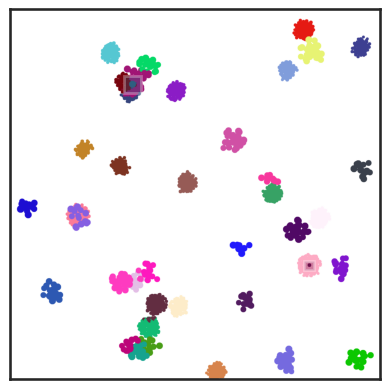

In [ ]:
f, ax = plt.subplots()
im = colony(x,20000,ax=ax)
colony(x,0,colony=11,ax=ax,img=im,overlay=True)
colony(x,0,colony=22,ax=ax,img=im,overlay=True)
plt.show()

In [ ]:
im.shape

(2000, 2000, 3)